In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 92)
(631390, 1)
validation
(74368, 92)
(74368, 1)
test
(85358, 92)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:28 - loss: 0.1025 - STD: 5.9720e-05 - MAE: 0.3089

 6/64 [=>............................] - ETA: 0s - loss: 0.0391 - STD: 5.2130e-05 - MAE: 0.1530  

11/64 [====>.........................] - ETA: 0s - loss: 0.0348 - STD: 3.8528e-05 - MAE: 0.1428

16/64 [======>.......................] - ETA: 0s - loss: 0.0285 - STD: 3.5283e-05 - MAE: 0.1227

21/64 [========>.....................] - ETA: 0s - loss: 0.0258 - STD: 3.7500e-05 - MAE: 0.1208

26/64 [===========>..................] - ETA: 0s - loss: 0.0234 - STD: 3.9508e-05 - MAE: 0.1108

27/64 [===========>..................] - ETA: 1s - loss: 0.0233 - STD: 3.9770e-05 - MAE: 0.1089

32/64 [==============>...............] - ETA: 0s - loss: 0.0219 - STD: 4.1769e-05 - MAE: 0.1014

37/64 [================>.............] - ETA: 0s - loss: 0.0206 - STD: 4.5304e-05 - MAE: 0.0976

42/64 [==================>...........] - ETA: 0s - loss: 0.0197 - STD: 4.9393e-05 - MAE: 0.0960

47/64 [=====================>........] - ETA: 0s - loss: 0.0190 - STD: 5.3152e-05 - MAE: 0.0930

52/64 [=======================>......] - ETA: 0s - loss: 0.0184 - STD: 5.6926e-05 - MAE: 0.0903

57/64 [=========================>....] - ETA: 0s - loss: 0.0179 - STD: 6.1442e-05 - MAE: 0.0887

62/64 [============================>.] - ETA: 0s - loss: 0.0175 - STD: 6.6325e-05 - MAE: 0.0875

64/64 [==============================] - 3s 31ms/step - loss: 0.0173 - STD: 6.8286e-05 - MAE: 0.0870 - val_loss: 0.0169 - val_STD: 1.1043e-04 - val_MAE: 0.0769


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0127 - STD: 1.3230e-04 - MAE: 0.0674

 6/64 [=>............................] - ETA: 0s - loss: 0.0127 - STD: 1.3867e-04 - MAE: 0.0669

11/64 [====>.........................] - ETA: 0s - loss: 0.0127 - STD: 1.4750e-04 - MAE: 0.0686

16/64 [======>.......................] - ETA: 0s - loss: 0.0126 - STD: 1.5633e-04 - MAE: 0.0695

21/64 [========>.....................] - ETA: 0s - loss: 0.0127 - STD: 1.6502e-04 - MAE: 0.0695

26/64 [===========>..................] - ETA: 0s - loss: 0.0127 - STD: 1.7461e-04 - MAE: 0.0696

31/64 [=============>................] - ETA: 0s - loss: 0.0127 - STD: 1.8502e-04 - MAE: 0.0698

36/64 [===============>..............] - ETA: 0s - loss: 0.0127 - STD: 1.9617e-04 - MAE: 0.0699

41/64 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.0812e-04 - MAE: 0.0699

47/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.2403e-04 - MAE: 0.0699

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.3867e-04 - MAE: 0.0699

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.5462e-04 - MAE: 0.0698

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.7261e-04 - MAE: 0.0698

64/64 [==============================] - 1s 12ms/step - loss: 0.0127 - STD: 2.8033e-04 - MAE: 0.0699 - val_loss: 0.0167 - val_STD: 4.4920e-04 - val_MAE: 0.0792


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0130 - STD: 5.3980e-04 - MAE: 0.0710

 6/64 [=>............................] - ETA: 0s - loss: 0.0127 - STD: 5.7757e-04 - MAE: 0.0701

11/64 [====>.........................] - ETA: 0s - loss: 0.0127 - STD: 6.2029e-04 - MAE: 0.0701

16/64 [======>.......................] - ETA: 0s - loss: 0.0126 - STD: 6.6772e-04 - MAE: 0.0700

22/64 [=========>....................] - ETA: 0s - loss: 0.0127 - STD: 7.3459e-04 - MAE: 0.0697

27/64 [===========>..................] - ETA: 0s - loss: 0.0127 - STD: 8.0199e-04 - MAE: 0.0698

32/64 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 8.8095e-04 - MAE: 0.0699

37/64 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 9.7448e-04 - MAE: 0.0698

42/64 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0697    

47/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 0.0012 - MAE: 0.0697

52/64 [=======================>......] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0696

57/64 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 0.0016 - MAE: 0.0693

62/64 [============================>.] - ETA: 0s - loss: 0.0124 - STD: 0.0019 - MAE: 0.0692

64/64 [==============================] - 1s 12ms/step - loss: 0.0124 - STD: 0.0020 - MAE: 0.0691 - val_loss: 0.0155 - val_STD: 0.0058 - val_MAE: 0.0748


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0121 - STD: 0.0071 - MAE: 0.0673

 7/64 [==>...........................] - ETA: 0s - loss: 0.0114 - STD: 0.0088 - MAE: 0.0667

12/64 [====>.........................] - ETA: 0s - loss: 0.0112 - STD: 0.0108 - MAE: 0.0657

17/64 [======>.......................] - ETA: 0s - loss: 0.0107 - STD: 0.0136 - MAE: 0.0641

22/64 [=========>....................] - ETA: 0s - loss: 0.0102 - STD: 0.0174 - MAE: 0.0623

27/64 [===========>..................] - ETA: 0s - loss: 0.0096 - STD: 0.0225 - MAE: 0.0601

32/64 [==============>...............] - ETA: 0s - loss: 0.0090 - STD: 0.0286 - MAE: 0.0578

37/64 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.0349 - MAE: 0.0555

42/64 [==================>...........] - ETA: 0s - loss: 0.0077 - STD: 0.0409 - MAE: 0.0534

47/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0464 - MAE: 0.0514

52/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0515 - MAE: 0.0496

57/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0558 - MAE: 0.0482

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0469

64/64 [==============================] - 1s 12ms/step - loss: 0.0059 - STD: 0.0610 - MAE: 0.0465 - val_loss: 0.0033 - val_STD: 0.0816 - val_MAE: 0.0359


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1044 - MAE: 0.0320

 6/64 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1029 - MAE: 0.0322

11/64 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0324

16/64 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0326

22/64 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0326

27/64 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0325

32/64 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0325

37/64 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0325

42/64 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0325

47/64 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0325

52/64 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0324

57/64 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324

62/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0324

64/64 [==============================] - 1s 12ms/step - loss: 0.0024 - STD: 0.1016 - MAE: 0.0324 - val_loss: 0.0031 - val_STD: 0.0806 - val_MAE: 0.0353


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

 6/64 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0321

11/64 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0320

16/64 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0321

21/64 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0320

26/64 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0320

31/64 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0320

36/64 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0319

41/64 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

46/64 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

51/64 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

57/64 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0319

62/64 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0319

64/64 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.1018 - MAE: 0.0318 - val_loss: 0.0029 - val_STD: 0.0822 - val_MAE: 0.0345


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0319

 6/64 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0318

11/64 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0316

16/64 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0315

21/64 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0314

26/64 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0315

31/64 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0314

36/64 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0314

41/64 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0314

47/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0314

52/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0314

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0314

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0314

64/64 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314 - val_loss: 0.0028 - val_STD: 0.0820 - val_MAE: 0.0340


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0310

 6/64 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1018 - MAE: 0.0309

11/64 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0310

16/64 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0311

21/64 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0311

26/64 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0311

31/64 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0311

36/64 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0311

41/64 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0311

46/64 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

51/64 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

57/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

62/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0310

64/64 [==============================] - 1s 12ms/step - loss: 0.0021 - STD: 0.1024 - MAE: 0.0310 - val_loss: 0.0027 - val_STD: 0.0849 - val_MAE: 0.0334


Epoch 9/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0307

 6/64 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0307

11/64 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0308

16/64 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0307

21/64 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0307

26/64 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0307

31/64 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0307

36/64 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0307

41/64 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0307

46/64 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0307

52/64 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0307

57/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0307

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0307

64/64 [==============================] - 1s 12ms/step - loss: 0.0021 - STD: 0.1026 - MAE: 0.0307 - val_loss: 0.0027 - val_STD: 0.0873 - val_MAE: 0.0331


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1053 - MAE: 0.0316

 6/64 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0308

11/64 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0307

16/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0306

21/64 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0306

26/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0306

31/64 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0305

36/64 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0305

41/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0305

46/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0305

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0305

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0304

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0304

64/64 [==============================] - 1s 12ms/step - loss: 0.0020 - STD: 0.1031 - MAE: 0.0304 - val_loss: 0.0026 - val_STD: 0.0868 - val_MAE: 0.0327


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0307

 6/64 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

11/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0302

16/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

21/64 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

27/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0301

32/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0301

37/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0302

42/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0302

47/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

64/64 [==============================] - 1s 12ms/step - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302 - val_loss: 0.0025 - val_STD: 0.0853 - val_MAE: 0.0323


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0299

 6/64 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0303

11/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

16/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0301

21/64 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

26/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

31/64 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

36/64 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0302

41/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0302

46/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0301

64/64 [==============================] - 1s 12ms/step - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301 - val_loss: 0.0025 - val_STD: 0.0873 - val_MAE: 0.0321


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0296

 7/64 [==>...........................] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300

12/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0301

17/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

22/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0301

27/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

32/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

37/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

42/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0300

47/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0300

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0299

64/64 [==============================] - 1s 12ms/step - loss: 0.0020 - STD: 0.1035 - MAE: 0.0299 - val_loss: 0.0024 - val_STD: 0.0856 - val_MAE: 0.0320


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0298

 6/64 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0299

11/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0299

16/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

21/64 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0299

26/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

31/64 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0298

36/64 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

41/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0298

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0298

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297

64/64 [==============================] - 1s 12ms/step - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297 - val_loss: 0.0024 - val_STD: 0.0884 - val_MAE: 0.0317


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0303

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0295

11/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0298

22/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0298

27/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0298

32/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0298

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0298

42/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

64/64 [==============================] - 1s 12ms/step - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297 - val_loss: 0.0024 - val_STD: 0.0880 - val_MAE: 0.0315


Epoch 16/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0296

12/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295

22/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0295

27/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

32/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

42/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0295

64/64 [==============================] - 1s 12ms/step - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295 - val_loss: 0.0024 - val_STD: 0.0880 - val_MAE: 0.0320


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0294

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0295

11/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

16/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0294

21/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

26/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0294

31/64 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0294

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0294

42/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0293

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0294

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0294

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0294

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0293

64/64 [==============================] - 1s 12ms/step - loss: 0.0019 - STD: 0.1037 - MAE: 0.0293 - val_loss: 0.0024 - val_STD: 0.0887 - val_MAE: 0.0312


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0292

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0293

12/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0293

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

22/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0293

27/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0293

32/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0293

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0293

42/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0292

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0292

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0292

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0292

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0292

64/64 [==============================] - 1s 12ms/step - loss: 0.0019 - STD: 0.1039 - MAE: 0.0292 - val_loss: 0.0024 - val_STD: 0.0884 - val_MAE: 0.0311


Epoch 19/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0290

11/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0291

16/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0291

21/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0291

26/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0291

31/64 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0291

36/64 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0291

41/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0290

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0290

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0291

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0291

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0291

64/64 [==============================] - 1s 12ms/step - loss: 0.0019 - STD: 0.1038 - MAE: 0.0291 - val_loss: 0.0024 - val_STD: 0.0904 - val_MAE: 0.0314


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1076 - MAE: 0.0293

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0292

12/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0292

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0292

22/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0292

27/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0293

32/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0292

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0292

42/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0292

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0292

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0291

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0291

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0291

64/64 [==============================] - 1s 12ms/step - loss: 0.0019 - STD: 0.1040 - MAE: 0.0291 - val_loss: 0.0024 - val_STD: 0.0907 - val_MAE: 0.0312


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0294

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0295

11/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

16/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0291

21/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0292

26/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0291

31/64 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0291

36/64 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0291

41/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0290

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0290

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0290

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0290

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289 - val_loss: 0.0023 - val_STD: 0.0881 - val_MAE: 0.0308


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0285

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288 - val_loss: 0.0023 - val_STD: 0.0890 - val_MAE: 0.0309


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1097 - MAE: 0.0279

 5/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

10/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

15/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

20/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

35/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287 - val_loss: 0.0023 - val_STD: 0.0892 - val_MAE: 0.0306


Epoch 24/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0288

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287 - val_loss: 0.0023 - val_STD: 0.0907 - val_MAE: 0.0305


Epoch 25/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287 - val_loss: 0.0022 - val_STD: 0.0900 - val_MAE: 0.0304


Epoch 26/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0289

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0290

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0289

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0289

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286 - val_loss: 0.0022 - val_STD: 0.0891 - val_MAE: 0.0305


Epoch 27/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0283

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287 - val_loss: 0.0022 - val_STD: 0.0904 - val_MAE: 0.0303


Epoch 28/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0280

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0285

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0287

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286 - val_loss: 0.0022 - val_STD: 0.0897 - val_MAE: 0.0303


Epoch 29/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0282

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.0882 - val_MAE: 0.0304


Epoch 30/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0287

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0285

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285 - val_loss: 0.0023 - val_STD: 0.0900 - val_MAE: 0.0313


Epoch 31/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0295

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0288

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287 - val_loss: 0.0022 - val_STD: 0.0893 - val_MAE: 0.0304


Epoch 32/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0285

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.0887 - val_MAE: 0.0301


Epoch 33/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0284

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0284

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0284

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0284

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0284

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.0898 - val_MAE: 0.0302


Epoch 34/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0285

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0284

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0285

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.0905 - val_MAE: 0.0300


Epoch 35/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0284

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0284

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0284

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0283

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0284

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284 - val_loss: 0.0021 - val_STD: 0.0894 - val_MAE: 0.0301


Epoch 36/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0284

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0284

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0283

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284 - val_loss: 0.0022 - val_STD: 0.0911 - val_MAE: 0.0301


Epoch 37/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0284

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.0908 - val_MAE: 0.0301


Epoch 38/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0278

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0282

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0283

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0282

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0283

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0283 - val_loss: 0.0022 - val_STD: 0.0906 - val_MAE: 0.0302


Epoch 39/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0282

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0283

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0283

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0283

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0283

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0284

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284 - val_loss: 0.0022 - val_STD: 0.0890 - val_MAE: 0.0306


Epoch 40/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0288

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0284

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0284

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0284

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0284

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0284

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0284 - val_loss: 0.0022 - val_STD: 0.0904 - val_MAE: 0.0300


Epoch 41/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0277

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0889 - val_MAE: 0.0300


Epoch 42/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0281

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0282

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0283

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

64/64 [==============================] - 1s 12ms/step - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0894 - val_MAE: 0.0299


Epoch 43/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0282

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0282

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0283

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0283

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282 - val_loss: 0.0022 - val_STD: 0.0907 - val_MAE: 0.0305


Epoch 44/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0283

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0898 - val_MAE: 0.0297


Epoch 45/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0283

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0283

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0900 - val_MAE: 0.0298


Epoch 46/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0277

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0901 - val_MAE: 0.0298


Epoch 47/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0283

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282 - val_loss: 0.0022 - val_STD: 0.0894 - val_MAE: 0.0304


Epoch 48/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0280

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0282

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282 - val_loss: 0.0021 - val_STD: 0.0898 - val_MAE: 0.0297


Epoch 49/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0282

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

64/64 [==============================] - 1s 11ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282 - val_loss: 0.0021 - val_STD: 0.0901 - val_MAE: 0.0303


Epoch 50/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0281

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282 - val_loss: 0.0021 - val_STD: 0.0896 - val_MAE: 0.0297


Epoch 51/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0277

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282 - val_loss: 0.0021 - val_STD: 0.0903 - val_MAE: 0.0302


Epoch 52/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0283

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0282

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0899 - val_MAE: 0.0296


Epoch 53/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0285

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0890 - val_MAE: 0.0307


Epoch 54/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0287

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

12/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0282

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0901 - val_MAE: 0.0298


Epoch 55/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0280

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0902 - val_MAE: 0.0296


Epoch 56/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0284

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0892 - val_MAE: 0.0296


Epoch 57/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282 - val_loss: 0.0020 - val_STD: 0.0899 - val_MAE: 0.0295


Epoch 58/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0278

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280 - val_loss: 0.0022 - val_STD: 0.0922 - val_MAE: 0.0306


Epoch 59/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

64/64 [==============================] - 1s 11ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0905 - val_MAE: 0.0296


Epoch 60/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 0s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0281

12/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0917 - val_MAE: 0.0296


Epoch 61/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0279

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282 - val_loss: 0.0021 - val_STD: 0.0919 - val_MAE: 0.0296


Epoch 62/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0279

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0279

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281 - val_loss: 0.0022 - val_STD: 0.0912 - val_MAE: 0.0305


Epoch 63/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0280

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280 - val_loss: 0.0021 - val_STD: 0.0909 - val_MAE: 0.0295


Epoch 64/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

 6/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0278

11/64 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0280

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0280

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

64/64 [==============================] - 1s 12ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280 - val_loss: 0.0021 - val_STD: 0.0910 - val_MAE: 0.0295


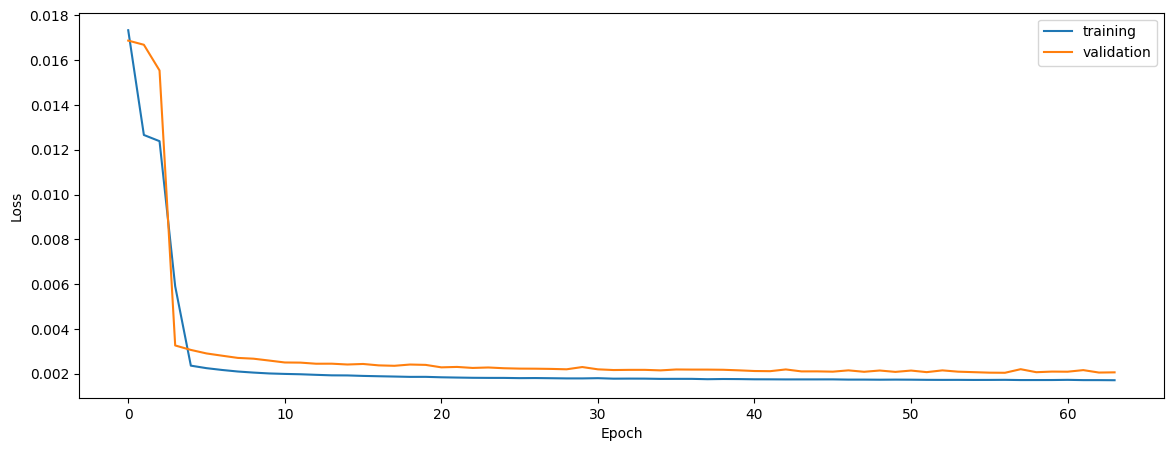

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9303607641873225
0.9379111063557984
0.9408518315596998


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9303607641873225
0.9379111063557984
0.9408518315596998


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9375269507641983
0.9414014468628168
0.9544139801752127


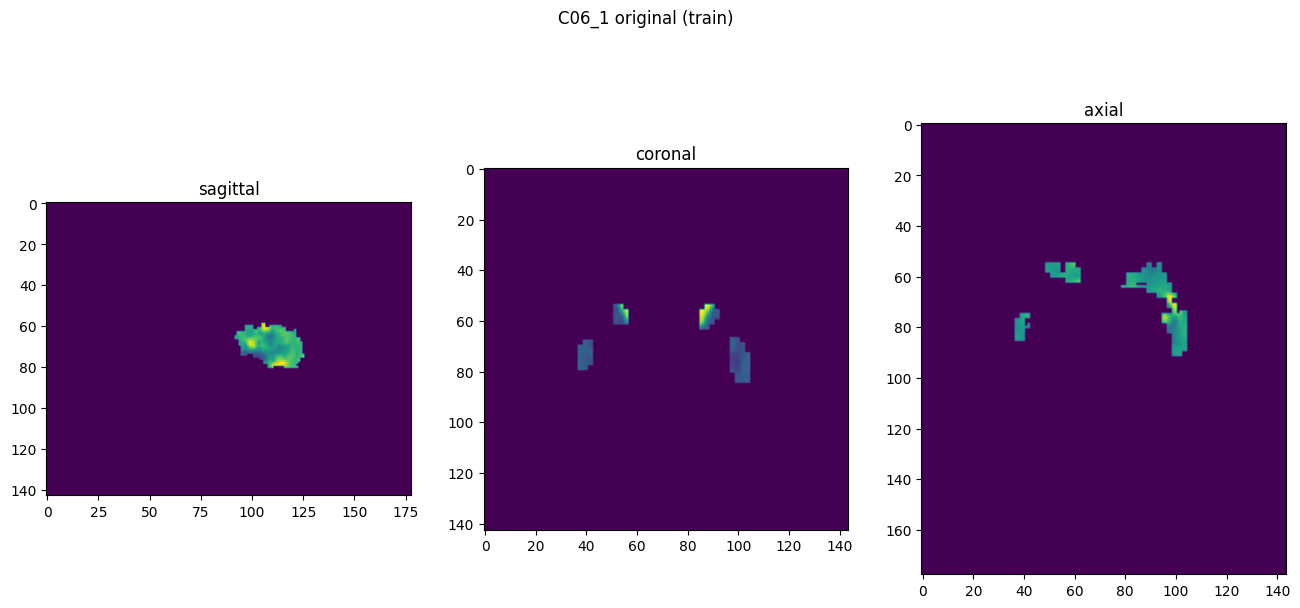

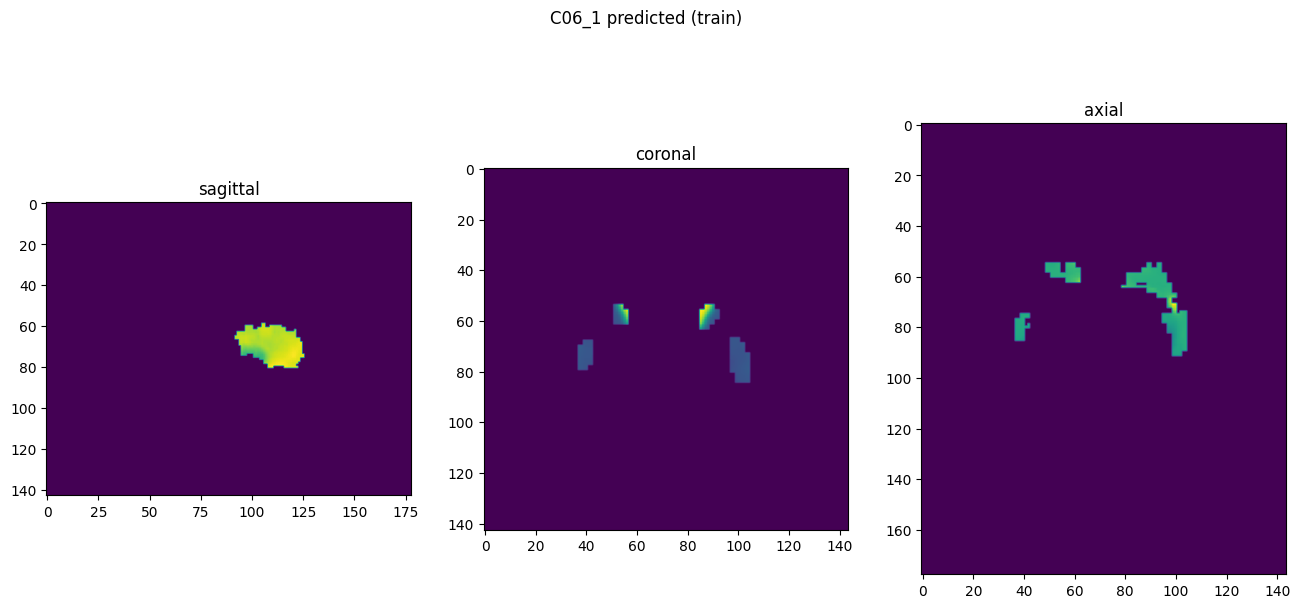

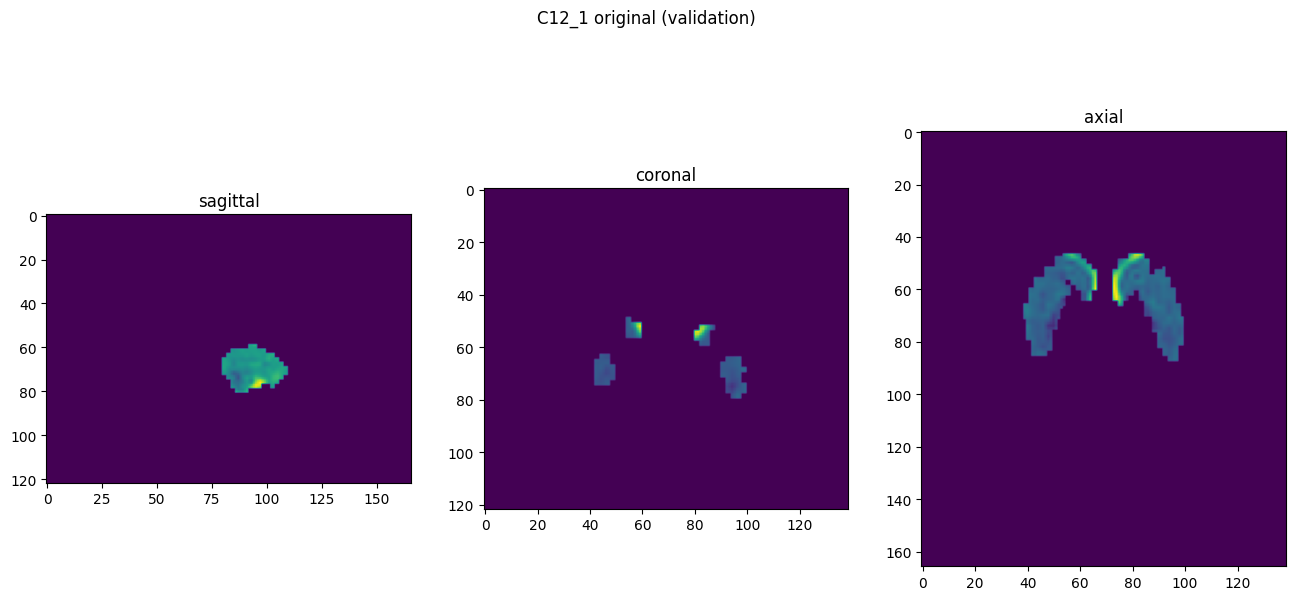

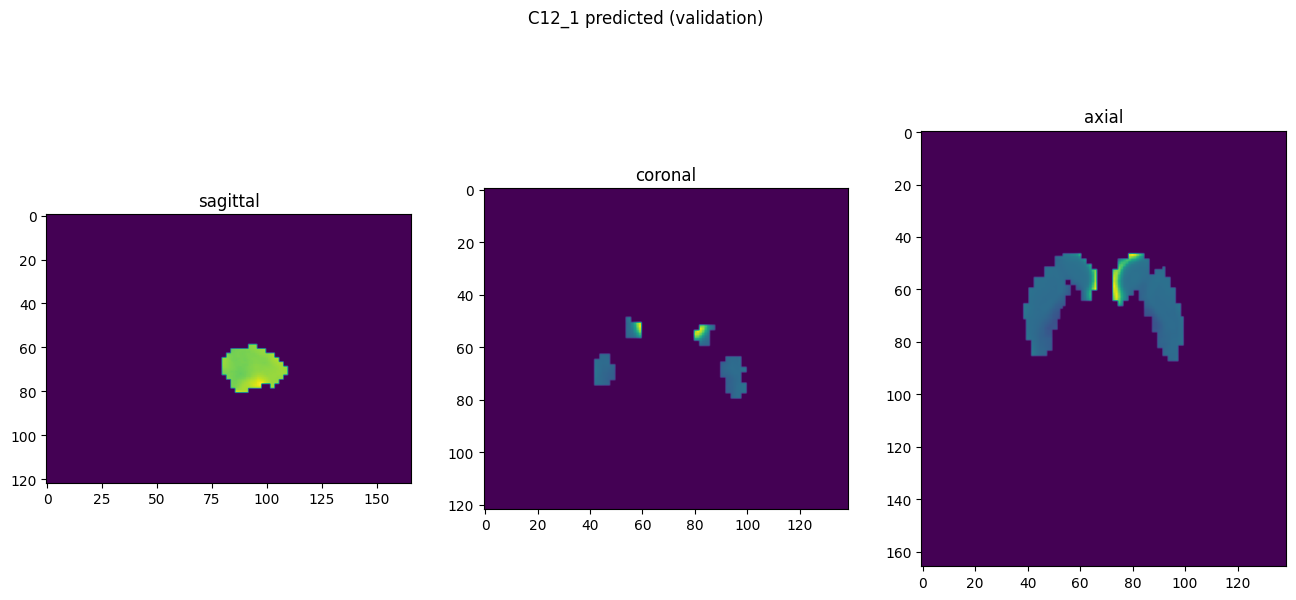

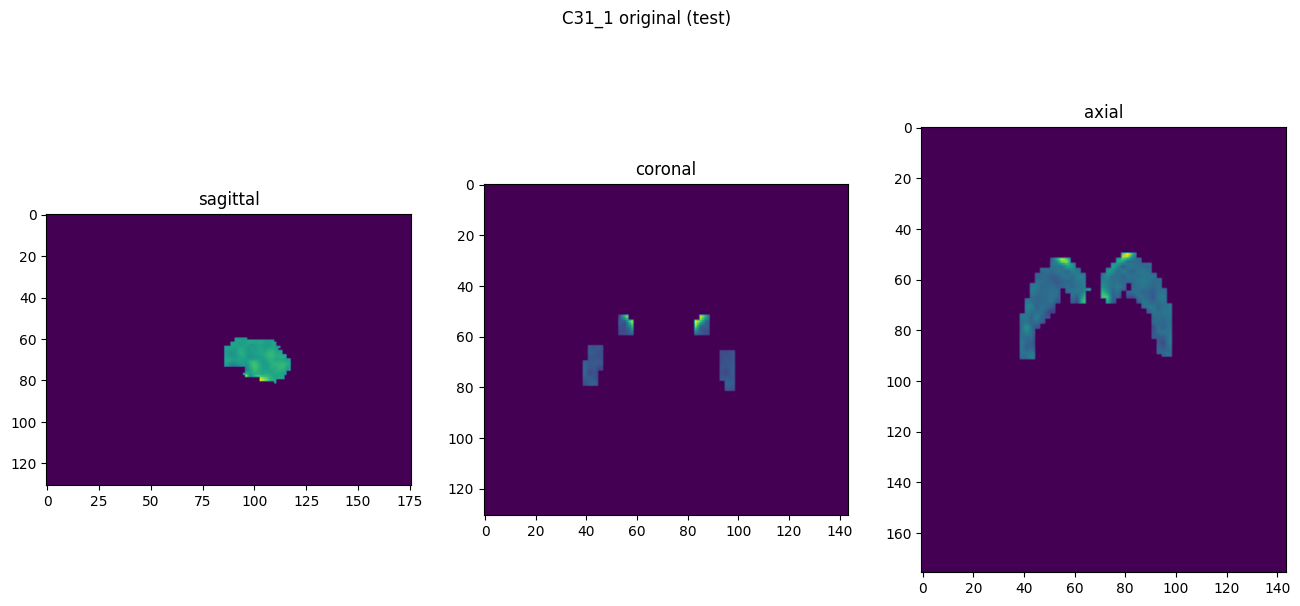

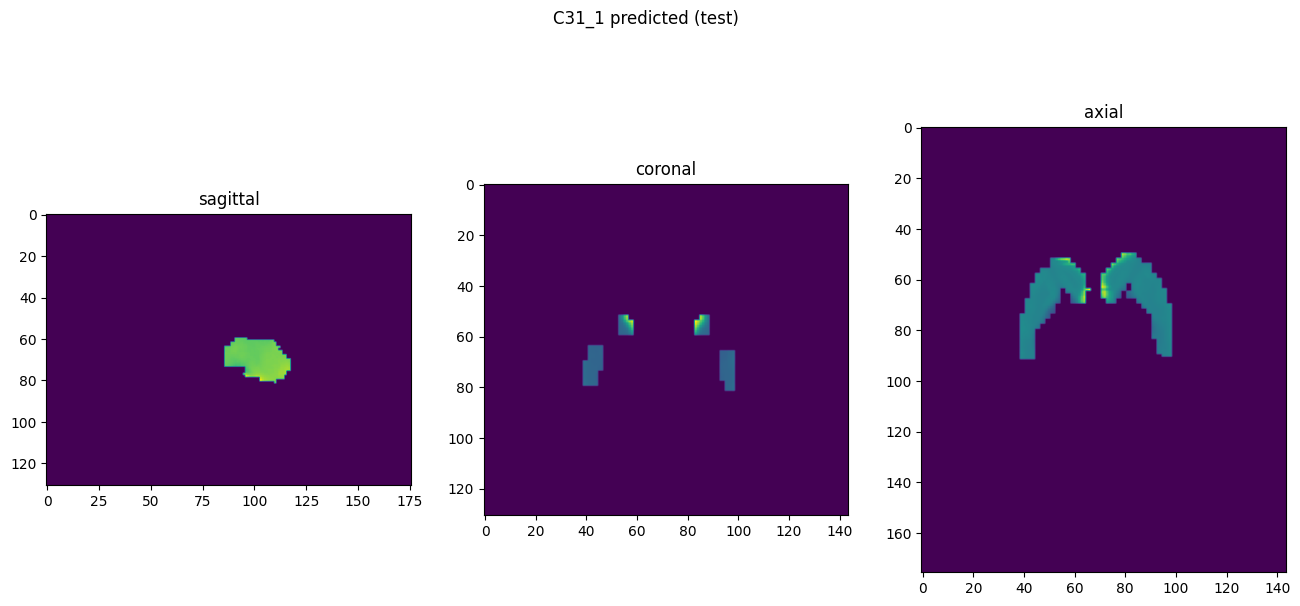

In [10]:
showResults(model, gen, threshold=None, background=False)